
recotwix comprises a set of utilities for reconstructing MR images from Siemens rawdata files (.dat).
The goal is to offer distinct Python scripts (classes) for reconstructing various sequence types. These classes inherit from 'recotwix', the parent class, which furnishes fundamental reconstruction routines and several general utilities.

### Requirments

recotwix uses [twixtools](https://github.com/pehses/twixtools) for raw data reading purposes. It has undergone testing and validation with Python 3.10.
Other packages needed:
 - numpy 
 - torch 
 - scipy
 - nibabel 
 - tqdm
 
recotwix also employs [BART](https://github.com/mrirecon/bart) for coil sensitivity calculation and combination. 

###  Installation
open terminal and simply navigate to the recotwix and install it with pip:

    pip install .

### Demo
The provided examples showcase the reconstruction of a B0 map derived from a double-echo GRE sequence and a B1+ map from a [ 3D satTFL](https://doi.org/10.1002/mrm.29459) sequence.

Software version: VD/VE (!?)

Scan  0


100%|██████████| 949M/949M [00:01<00:00, 683MB/s] 
k-space to image: 100%|██████████| 32/32 [00:00<00:00, 98.54it/s] 


Calculating B0 map. ΔTE = 3500 μs
Unwrapping B0...


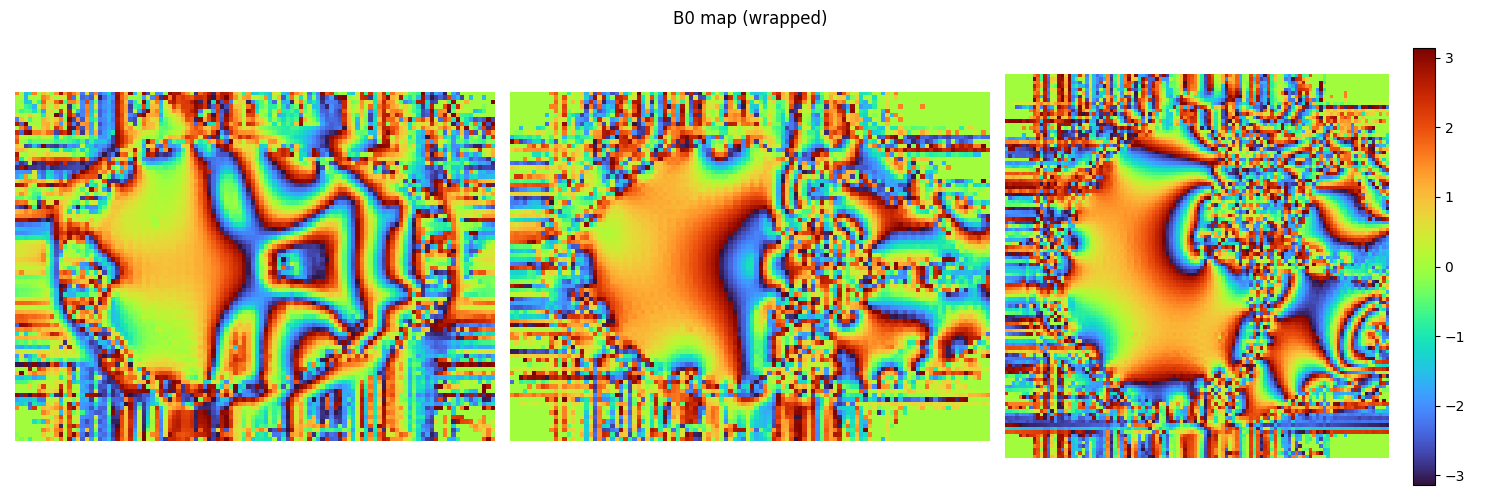

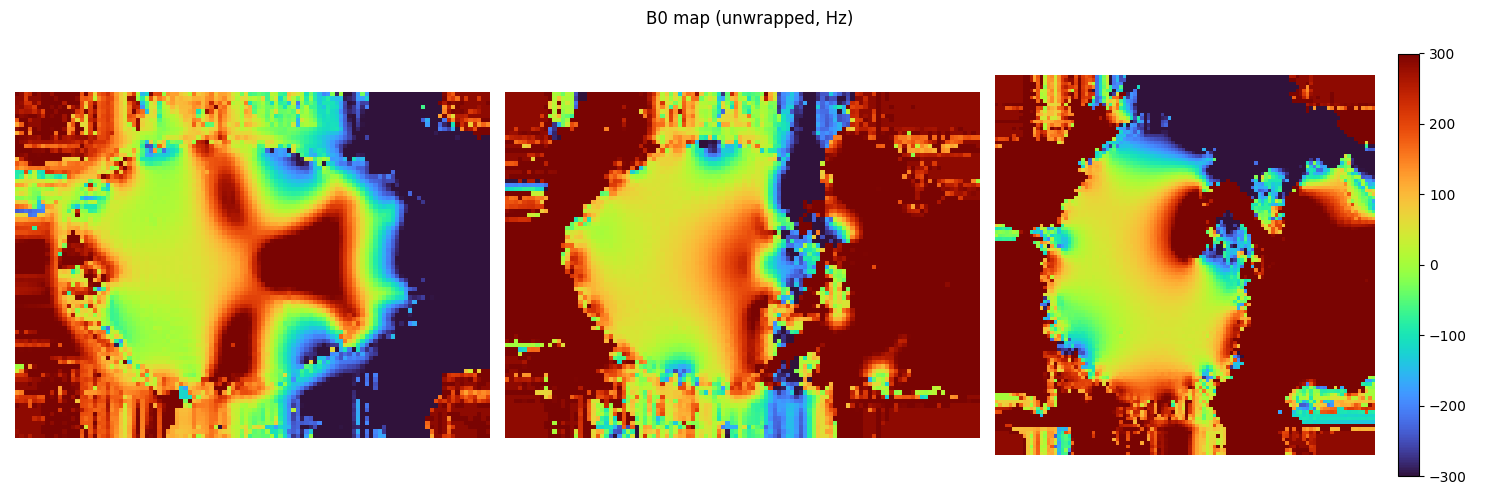

In [1]:
%matplotlib widget
from recotwix.sequences import recoB0
from pytools import plot

filename = '/DATA2/rawdata/twixtools_samples/meas_MID00575_FID29449_aa_B0Phantom.dat'
B0 = recoB0(filename)

plot.plot3D(B0.img_b0, title='B0 map (wrapped)')
plot.plot3D(B0.get_b0hz(), clim = [-300, 300], title='B0 map (unwrapped, Hz)')


Software version: VD/VE (!?)

Scan  0


100%|██████████| 513M/513M [00:01<00:00, 281MB/s] 


kspace shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 34, 1, 1, 48, 1, 1, 64, 32, 48])
kspace corrected shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 34, 1, 1, 48, 1, 1, 64, 32, 64])
POCS reconstruction along dim = 15 started...


image to k-space: 100%|██████████| 32/32 [00:00<00:00, 233.23it/s]


Computing coil sensitivity...
kernel_size: 32
Calibration region 32x24x24
Done.
Combining coils... 


k-space to image: 100%|██████████| 32/32 [00:01<00:00, 18.81it/s]


GPU reconstruction
Size: 6684672 Samples: 1671167 Acc: 4.00
Inverse scaling of the data: 0.000001
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
lsqr: add GPU wrapper
	 cg:  30
Total Time: 7.092063
torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 48, 1, 1, 64, 1, 64])
torch.Size([1, 1, 1, 1, 1, 1, 1, 34, 1, 1, 48, 1, 1, 64, 1, 64])
torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 48, 1, 1, 64, 1, 64])


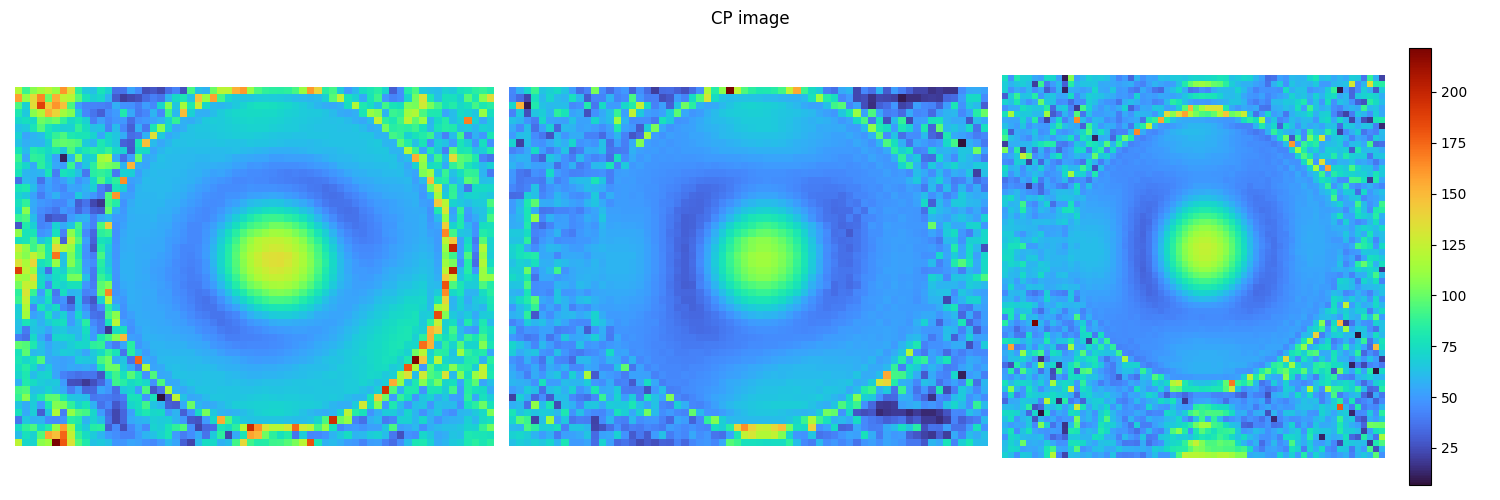

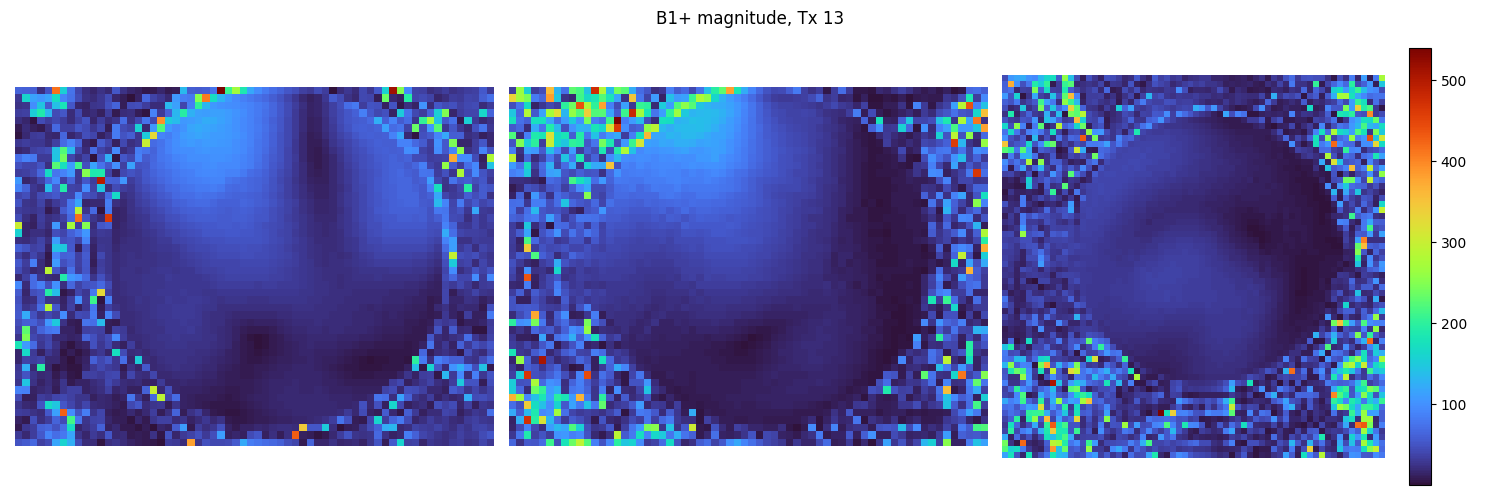

In [1]:
%matplotlib widget
from recotwix.sequences import recoB1TFLpTx
from pytools import plot
import torch

filename = '/DATA2/rawdata/twixtools_samples/meas_MID00866_FID61816_db_TFLb1_ICE_48Slc.dat'
twix = recoB1TFLpTx(filename)

print(twix.img_cp.shape)
print(twix.img.shape)
print(twix.img.abs().index_select(twix.dim_info['Rep']['ind'], torch.Tensor([0]).int()).shape)
plot.plot3D(twix.img_cp.abs(), title='CP image')
plot.plot3D(twix.img_fa.abs().index_select(twix.dim_info['Rep']['ind'], torch.Tensor([12]).int()), title='B1+ magnitude, Tx 13')


In [5]:
import recotwix.prot_volumes as prot_volumes
import recotwix.transformation as transformation
import numpy as np
import recotwix 
import os
import glob

np.set_printoptions(precision=3, suppress=True)

directory = '/DATA2/rawdata/rawdata_for_affine_transform/'
# directory = '/DATA2/rawdata/rawdata_for_affine_transform/single_slice'
# directory = '/DATA2/rawdata/rawdata_for_affine_transform/simple_cases_1/'
# directory = '/DATA2/rawdata/rawdata_for_affine_transform/simple_cases_2/'
# directory = '/DATA2/rawdata/rawdata_for_affine_transform/protocol_dump/'

files_in_dir = sorted(glob.glob(os.path.join(directory, '*.txt')))

# files_in_dir = [os.path.join(directory, 'c_s_inplane10_3d.txt')]
# files_in_dir = [os.path.join(directory, 's_2d_PEReducedFoV_PENoShift.txt')]

for file in files_in_dir:
    print('='*50)
    print(f"File name: {os.path.basename(file)}")
    twixfile = os.path.splitext(file)[0] + '.dat'
    # nii_file = glob.glob(os.path.join(directory, 'dcm', os.path.splitext(os.path.basename(file))[0], '*.nii'))[0]

    reco = recotwix.recotwix(twixfile)
    prot = prot_volumes.prot_volumes(reco.hdr)
    txt  = prot_volumes.prot_volumes(file)

    # reco.runReco(method_sensitivity=None)
    # reco.write_nifti(reco.img.abs(), os.path.splitext(file)[0] + '.nii')

    # print('\n', reco.transformation['mat44'])
    # print('\n', prot.slc.transformation)
    # print('\n', txt.slc.transformation)
    # print('\n', reco.transformation['nii_affine'])
    file_name = os.path.splitext(os.path.basename(file))[0]
    folder_name = os.path.join(directory, file_name)
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    txt.adj.write_nifti(os.path.join(directory, file_name, 'adj.nii'))
    for i, slc in enumerate(txt.slc):
        print('\n', slc.affine)
        slc.write_nifti(os.path.join(directory, file_name, f'slc_{i+1:03d}.nii'))


File name: 1.txt

 [[  0.      0.     -2.      7.   ]
 [ -1.732  -1.      0.    184.851]
 [ -1.      1.732   0.    -38.851]
 [  0.      0.      0.      1.   ]]

 [[  0.      0.     -2.      1.   ]
 [ -1.732  -1.      0.    184.851]
 [ -1.      1.732   0.    -38.851]
 [  0.      0.      0.      1.   ]]

 [[  0.      0.     -2.     -5.   ]
 [ -1.732  -1.      0.    184.851]
 [ -1.      1.732   0.    -38.851]
 [  0.      0.      0.      1.   ]]

 [[  0.      0.     -2.    -11.   ]
 [ -1.732  -1.      0.    184.851]
 [ -1.      1.732   0.    -38.851]
 [  0.      0.      0.      1.   ]]

 [[  0.      0.     -2.    -17.   ]
 [ -1.732  -1.      0.    184.851]
 [ -1.      1.732   0.    -38.851]
 [  0.      0.      0.      1.   ]]
File name: 2.txt

 [[  0.      0.     -2.      7.   ]
 [  1.     -1.732   0.     56.851]
 [ -1.732  -1.      0.    182.851]
 [  0.      0.      0.      1.   ]]

 [[  0.      0.     -2.      1.   ]
 [  1.     -1.732   0.     56.851]
 [ -1.732  -1.      0.    182.851]
 

In [1]:
import recotwix.transformation as transformation
import recotwix.prot_volumes as prot_volumes
import nibabel as nib

nii_file = '/DATA2/rawdata/rawdata_for_affine_transform/protocol_dump/localizer.nii'
txt_file = '/DATA2/rawdata/rawdata_for_affine_transform/protocol_dump/6.txt'

nii = nib.load(nii_file)
txt = prot_volumes.prot_volumes(txt_file)
data = nii.get_fdata()
v = txt.slc[0]

print(nii.affine)
print(v.affine)
print(data.shape, v.shape)

scl = 1
target_size = list(map(lambda x: x * scl, v.shape))
target_affine = v.affine.copy()
# target_affine[:,0:3] /= scl
# print(target_affine)

resliced_vol = transformation.reslice(data, nii.affine, reference_affine=target_affine, reference_size=target_size, interp_oder=3, fill_value=0)
print(resliced_vol.shape)
nii_img = nib.Nifti1Image(resliced_vol, v.affine)
nib.save(nii_img, '/DATA2/rawdata/rawdata_for_affine_transform/protocol_dump/localizer_resliced.nii')

[[  -2.            0.            0.          130.69836426]
 [   0.            2.            0.         -122.72131348]
 [   0.            0.            2.         -127.57711792]
 [   0.            0.            0.            1.        ]]
[[   0.            1.73205081    1.         -134.8550812 ]
 [  -2.            0.            0.          138.        ]
 [   0.           -1.            1.73205081   26.55060574]
 [   0.            0.            0.            1.        ]]
(128, 128, 112) (128, 128, 32)
(128, 128, 112)
(128, 128, 32)


In [1]:
import nibabel as nib
import numpy as np
from scipy import ndimage

nii_file = '/DATA2/rawdata/rawdata_for_affine_transform/protocol_dump/localizer.nii'
nii = nib.load(nii_file)
data = nii.get_fdata()
result = ndimage.zoom(data, 2.0)
affine = nii.affine
affine[:,0:3] = affine[:,0:3] / 2

nii_img = nib.Nifti1Image(result, affine)
nib.save(nii_img, '/DATA2/rawdata/rawdata_for_affine_transform/protocol_dump/localizer_upsampled.nii')